<a href="https://www.kaggle.com/code/pronoydeb/convnext-model?scriptVersionId=256678120" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <span style="color:coral"> <center> ConvNeXt with tensorflow</center> </span>

# <span >Notebook Overview</span>

* In this notebook I have implemented `ConvNext tiny` model from the research paper titled as [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) using tensorflow.

* The code in this notebook is reusable and can be reused with any dataset of your choice.

* In this notebook I will train `ConvNext tiny` model from scratch on CIFAR-10 dataset.


In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

# <span style="color:coral">Loading Data</span>

In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Path to the dataset
data_path = "/kaggle/input/rice-leaf-disease-dataset/Rice Leaf Disease Dataset"

def load_leaf_disease_dataset(dataset_path):
    images = []
    labels = []
    
    # Loop through all subsets: train, validation, and test
    for subset in ['train', 'validation', 'test']:
        subset_path = os.path.join(dataset_path, subset)
        
        # Loop through each disease folder in the subset
        for disease_name in os.listdir(subset_path):
            disease_path = os.path.join(subset_path, disease_name)
            if os.path.isdir(disease_path):
                for img_file in os.listdir(disease_path):
                    if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
                        img_path = os.path.join(disease_path, img_file)
                        try:
                            img = Image.open(img_path).convert("RGB")
                            img = img.resize((128, 128))
                            img_array = np.array(img)
                            images.append(img_array)
                            labels.append(disease_name)
                        except Exception as e:
                            print(f"Error loading {img_path}: {e}")

    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    # Encode string labels to numerical values
    le = LabelEncoder()
    labels = le.fit_transform(labels)

    return images, labels, le.classes_

# Load data
x_data, y_data, class_names = load_leaf_disease_dataset(data_path)

# Split into train and test sets (80-20 split)
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data,
    test_size=0.2,
    random_state=42,
    stratify=y_data
)

# Normalize images
x_train = x_train / 255.0
x_test = x_test / 255.0

# Output info
print(f"Classes detected: {class_names}")
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")


Classes detected: ['Healthy' 'Mild Bacterial blight' 'Mild Blast' 'Mild Brownspot'
 'Mild Tungro' 'Severe Bacterial blight' 'Severe Blast' 'Severe Brownspot'
 'Severe Tungro']
x_train shape: (2427, 128, 128, 3), y_train shape: (2427,)
x_test shape: (607, 128, 128, 3), y_test shape: (607,)


I will be using `tf.data` api which helps to build flexible and efficient input pipeline.
​
td.data allows us to do various tasks in memory efficient way such as :
​
* `map()` - maps a predefined function to dataset
* `shuffle()` - randomly shuffles the elements of a target 
* `batch()` - turns dataset into batches 
* `prefetch()` - prepares subsequent batches of data while other batches of data are being computed

In [3]:
AUTO = tf.data.AUTOTUNE
BATCH_SIZE=16
# convert images to float32 format and convert labels to int32
def preprocess (image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    label = tf.cast(label, tf.int32)
    return image, label

#Peform augmentations on training data
def augmentation(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    return image, label


train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#applying transformations 
train_data = train_data.shuffle(1024) # shuffle the images
train_data = train_data.map(preprocess, num_parallel_calls=AUTO)# mapping our preprocess function to train_data 
train_data = train_data.map(augmentation, num_parallel_calls=AUTO)# mapping our augmentation funtion to train_data
train_data = train_data.batch(BATCH_SIZE) #Converting train_data to batches
train_data = train_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#applying transformations 
test_data = test_data.map(preprocess, num_parallel_calls=AUTO) # mapping our preprocess function test_data 
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(AUTO) # using prefetch which prepares subsequent batches of data while other batches are being computed.

# <center>ConvNeXt Block</center>

For implementing `ConvNeXt` block authors take inspiration from the `ResNext` architecture which use [grouped convolutions](https://paperswithcode.com/method/grouped-convolution#:~:text=A%20Grouped%20Convolution%20uses%20a,level%20and%20high%20level%20features.), for `ConvNeXt` block authors utlize the combination of [depthwise convolutions](https://paperswithcode.com/method/depthwise-convolution) and 1x1 [point-wise convolutions](https://paperswithcode.com/method/pointwise-convolution). Depthwise convolutions reduce the number of parameters and computation used in convolutional operations while increasing representational efficiency. Pointwise convolutions is a 1x1 convolution which projects the channels output by the depthwise convolution onto a new channel space
 
In this paper authors use a slightly modified [inverted bottle-neck](https://paperswithcode.com/method/inverted-residual-block) design given by:

1. A depthwise convolution, authors found out that `7x7 size` depthwise convolution gives better performance than that of other sizes. followed by a layer norm normalization layer as used in transformer architectures.

2. `Layer normalization` is used after the depthwise convolution instead of the Batch Normalization. As opposed to ResNet Block architecture ConvNeXt block only uses `layer norm` once in a residual block. 

> `Note:` In batchnorm, the mean and variance used for normalization are calculated across all elements in a batch, for each feature independently while in layernorm, they are calculated across the feature dimension, for each element and instance independently. 

3. A 1x1 `pointwise convolution` is used after LN.

4. A [GELU](https://paperswithcode.com/method/gelu) activation function is used after 1x1 pointwise convolutional layer. As opposed to multiple ReLU activations in ResNet residual block, ConvNext uses GELU activation function only once in a residual block.

5. Another 1x1 `pointwise convolution` is used.

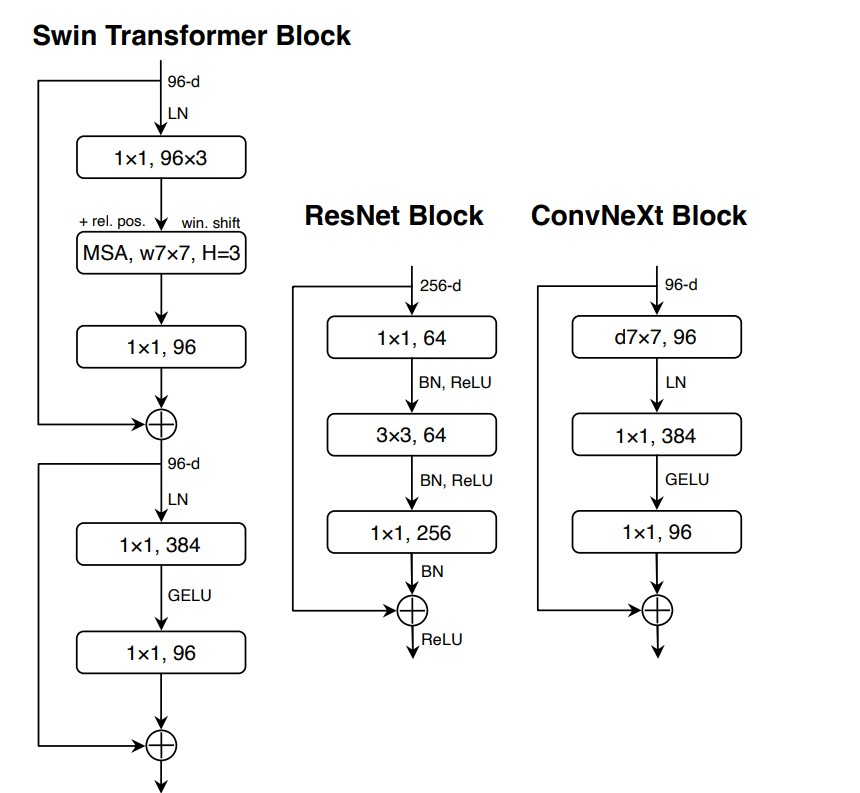

> Image source [A ConvNet for the 2020s](https://arxiv.org/abs/2201.03545) 

In [4]:
class ConvNext_Block(tf.keras.Model):
    
    """
    Implementing the ConvNeXt block for 
    
    Args:
        dim: No of input channels
        drop_path: stotchastic depth rate 
        layer_scale_init_value=1e-6
    
    Returns:
        A conv block
    """
    
    def __init__(self, dim, drop_path=0.0, layer_scale_init_value=1e-6, **kwargs):
        super(ConvNext_Block, self).__init__(**kwargs)
        
        self.depthwise_convolution = layers.Conv2D(dim, kernel_size=7, padding="same", groups=dim )
        self.layer_normalization = layers.LayerNormalization(epsilon=1e-6)
        self.pointwise_convolution_1 = layers.Dense(4 * dim)
        self.GELU = layers.Activation("gelu")
        self.pointwise_convolution_2 = layers.Dense(dim)
        self.gamma = tf.Variable(layer_scale_init_value * tf.ones((dim,)))
        if drop_path>0.0:
            self.drop_path=(tfa.layers.StochasticDepth(drop_path))
        else:
            self.drop_path=layers.Activation("linear")
        

    def call(self, inputs):
        x = inputs
        x = self.depthwise_convolution(x)
        x = self.layer_normalization(x)
        x = self.pointwise_convolution_1(x)
        x = self.GELU(x)
        x = self.pointwise_convolution_2(x)
        x = self.gamma * x

        return inputs + self.drop_path(x)


# Patchify Stem 

For processing the input images, ConvNeXt utilizes patchify strategy of transformers by 4x4 convolutional layer with stride of 4 i.e it will have non overlapping patches.

In [5]:
def patchify_stem(dims):
    """
    Implements the stem block of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
    
    Returns:
        feature maps after patchify operation
    """
    stem = keras.Sequential(
        [layers.Conv2D(dims[0], kernel_size=4, strides=4),
        layers.LayerNormalization(epsilon=1e-6)],
        )
    return stem

# Spatial Downsampling

Similar to Resnets and Swin Transformer, ConvNext perform spatial downsampling with `2x2` conv layer having `stride` of **2**. Authors of the paper observed that adding Layer Normalization layer gives significantly good performance.



In [6]:
def spatial_downsampling(stem,dims,kernel_size,stride):
    """
    Implements Spatial Downsampling of ConvNeXt
    
    Args:
        Dims: List of feature dimensions at each stage.
        stem: Patchify stem output of images
        kernel_size: Downsampling kernel_size
        stride: Downsampling stride length
    Returns:
        Downsampled layers
    """

    ds_layers = []
    ds_layers.append(stem)
    for dim in dims[1:]:
        layer = keras.Sequential(
            [layers.LayerNormalization(epsilon=1e-6),
            layers.Conv2D(dim, kernel_size=kernel_size, strides=stride),
            ]
        )
        ds_layers.append(layer)
        
    return ds_layers

# Convnext Stages
We will iteratively build the stages of ConvNeXt block by calling the ConvNext_Block function created earlier over the feature dimensions at each stage.

In [7]:
def ConvNext_Stages (dims,drop_path_rate,depths,layer_scale_init_value):
    """
    Creating stages each consiting of multiple residual blocks
    
    Args:
        dims: List of feature dimensions at each stage.
        drop_path_rate: Stochastic depth rate
        depths: Number of blocks at each stage
        layer_scale_init_value: Init value for Layer Scale
        
    """
    stages = []
    dropout_rates = [x for x in tf.linspace(0.0, drop_path_rate, sum(depths))]
    cur = 0
    for i in range(len(dims)):
        stage = keras.Sequential(
            [*[ConvNext_Block(dim=dims[i],drop_path=dropout_rates[cur + j],layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            ]
        )
        stages.append(stage)
        cur += depths[i]
    return stages

# Final ConvNeXt Model

In this implementaion I will be implementing the ConvNeXt-T having dimensions = (96, 192, 384, 768) and depths = (3, 3, 9, 3)

In [8]:
drop_path_rate=0.0
layer_scale_init_value=1e-6
dims=[1, 1, 1, 1]
depths=[3, 3, 9, 3]

In [9]:
inputs = layers.Input((32,32,3))
x = inputs

stem=patchify_stem(dims)

downsampling=spatial_downsampling(stem,dims,kernel_size=2,stride=2)

stages=ConvNext_Stages(dims,drop_path_rate,depths,layer_scale_init_value)

for i in range(len(stages)):
    x = downsampling[i](x)
    x = stages[i](x)

x = layers.GlobalAvgPool2D()(x)
x = layers.LayerNormalization(epsilon=1e-6)(x)

outputs = layers.Dense(10)(x)

ConvNeXt_model=keras.Model(inputs, outputs)

In [10]:
ConvNeXt_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 8, 8, 1)           51        
_________________________________________________________________
sequential_4 (Sequential)    (None, 8, 8, 1)           198       
_________________________________________________________________
sequential_1 (Sequential)    (None, 4, 4, 1)           7         
_________________________________________________________________
sequential_5 (Sequential)    (None, 4, 4, 1)           198       
_________________________________________________________________
sequential_2 (Sequential)    (None, 2, 2, 1)           7         
_________________________________________________________________
sequential_6 (Sequential)    (None, 2, 2, 1)           594   

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import classification_report

class MetricsLogger(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []
        
        for batch in self.validation_data:
            images, labels = batch
            preds = self.model.predict(images, verbose=0)
            preds = np.argmax(preds, axis=1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds)

        report = classification_report(y_true, y_pred, output_dict=False)
        print("\nValidation Classification Report:\n", report)


In [12]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [13]:
from tensorflow.keras import layers, models
import tensorflow as tf
import tensorflow_addons as tfa

# Define ConvNeXt with input_shape=(224, 224, 3)
def build_convnext_model(input_shape=(128, 128, 3), num_classes=len(class_names)):
    inputs = layers.Input(shape=input_shape)
    
    # Example ConvNeXt block (adjust architecture as needed)
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding="same")(inputs)
    x = layers.LayerNormalization()(x)
    x = layers.Activation("gelu")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)
    
    # Add more ConvNeXt blocks...
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes)(x)
    
    model = models.Model(inputs, outputs)
    return model

# Build model
ConvNeXt_model = build_convnext_model(input_shape=(128, 128, 3))

# Compile
ConvNeXt_model.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train
metrics_logger = MetricsLogger(validation_data=test_data)

history = ConvNeXt_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[metrics_logger, lr_scheduler, early_stopping]
)

Epoch 1/50
152/152 [==============================] - 17s 108ms/step - loss: 2.0093 - accuracy: 0.2592 - val_loss: 1.6878 - val_accuracy: 0.4316

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95        67
           1       0.30      0.82      0.44        67
           2       0.36      0.67      0.47        67
           3       0.00      0.00      0.00        67
           4       0.00      0.00      0.00        68
           5       0.35      0.46      0.40        67
           6       0.52      0.22      0.31        67
           7       0.00      0.00      0.00        69
           8       0.45      0.72      0.55        68

    accuracy                           0.43       607
   macro avg       0.32      0.43      0.35       607
weighted avg       0.32      0.43      0.35       607

Epoch 2/50
  1/152 [..............................] - ETA: 17s - loss: 1.7846 - accuracy: 0.3125

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152/152 [==============================] - 18s 116ms/step - loss: 1.5875 - accuracy: 0.4417 - val_loss: 1.4677 - val_accuracy: 0.5041

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        67
           1       0.42      0.79      0.55        67
           2       0.49      0.55      0.52        67
           3       0.71      0.54      0.61        67
           4       0.34      1.00      0.51        68
           5       0.59      0.39      0.47        67
           6       0.83      0.07      0.14        67
           7       0.00      0.00      0.00        69
           8       0.42      0.21      0.28        68

    accuracy                           0.50       607
   macro avg       0.52      0.51      0.45       607
weighted avg       0.52      0.50      0.45       607

Epoch 3/50
  1/152 [..............................] - ETA: 19s - loss: 1.5422 - accuracy: 0.3750

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152/152 [==============================] - 20s 129ms/step - loss: 1.4710 - accuracy: 0.4986 - val_loss: 1.4187 - val_accuracy: 0.4843

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94        67
           1       0.36      0.72      0.48        67
           2       0.66      0.28      0.40        67
           3       0.44      0.96      0.60        67
           4       0.62      0.71      0.66        68
           5       0.29      0.61      0.40        67
           6       1.00      0.10      0.19        67
           7       0.00      0.00      0.00        69
           8       0.00      0.00      0.00        68

    accuracy                           0.48       607
   macro avg       0.47      0.49      0.41       607
weighted avg       0.47      0.48      0.41       607

Epoch 4/50
  2/152 [..............................] - ETA: 14s - loss: 1.6798 - accuracy: 0.3750

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152/152 [==============================] - 16s 104ms/step - loss: 1.4115 - accuracy: 0.5175 - val_loss: 1.4256 - val_accuracy: 0.4465

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        67
           1       0.43      0.81      0.56        67
           2       0.34      0.75      0.46        67
           3       0.00      0.00      0.00        67
           4       0.00      0.00      0.00        68
           5       0.53      0.39      0.45        67
           6       0.60      0.22      0.33        67
           7       0.33      0.06      0.10        69
           8       0.32      0.81      0.46        68

    accuracy                           0.45       607
   macro avg       0.38      0.45      0.37       607
weighted avg       0.38      0.45      0.37       607

Epoch 5/50
  2/152 [..............................] - ETA: 14s - loss: 1.2871 - accuracy: 0.5625

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


152/152 [==============================] - 15s 101ms/step - loss: 1.3473 - accuracy: 0.5521 - val_loss: 1.2959 - val_accuracy: 0.5502

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96        67
           1       0.43      0.64      0.51        67
           2       0.92      0.34      0.50        67
           3       0.54      0.96      0.69        67
           4       0.52      0.85      0.64        68
           5       0.37      0.60      0.46        67
           6       1.00      0.07      0.14        67
           7       0.33      0.20      0.25        69
           8       0.91      0.29      0.44        68

    accuracy                           0.55       607
   macro avg       0.66      0.55      0.51       607
weighted avg       0.66      0.55      0.51       607

Epoch 6/50
152/152 [==============================] - 16s 103ms/step - loss: 1.2869 - accuracy: 0.5958 - val_loss: 1.2132 - v

In [14]:
# After training
y_pred = []
y_true = []

for images, labels in test_data:
    preds = ConvNeXt_model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))


                         precision    recall  f1-score   support

                Healthy       0.99      1.00      0.99        67
  Mild Bacterial blight       0.57      0.58      0.57        67
             Mild Blast       0.82      0.69      0.75        67
         Mild Brownspot       0.74      0.84      0.78        67
            Mild Tungro       0.79      0.78      0.79        68
Severe Bacterial blight       0.55      0.61      0.58        67
           Severe Blast       0.72      0.81      0.76        67
       Severe Brownspot       0.38      0.33      0.35        69
          Severe Tungro       0.85      0.76      0.81        68

               accuracy                           0.71       607
              macro avg       0.71      0.71      0.71       607
           weighted avg       0.71      0.71      0.71       607



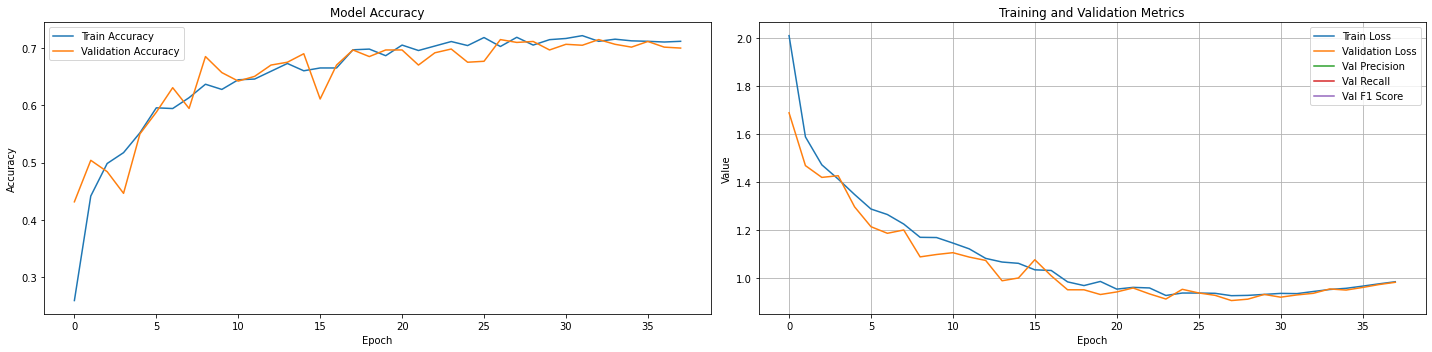

In [15]:
import matplotlib.pyplot as plt

# Plotting loss and accuracy curves
plt.figure(figsize=(20, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

# Precision, Recall, F1
plt.plot(history.history.get('val_precision', []), label='Val Precision')
plt.plot(history.history.get('val_recall', []), label='Val Recall')
plt.plot(history.history.get('val_f1', []), label='Val F1 Score')

plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
def get_img_array(img, size=(128, 128)):
    img = tf.image.resize(img, size)
    img = tf.expand_dims(img, axis=0)  # Add batch dimension
    return img

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Create model to map the last conv layer to output
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Record operations for gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Mean intensity of the gradients for each channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by its gradient importance
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize to 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(original_img, heatmap, alpha=0.4):
    # Convert to 0–255 range for display
    original_img = np.array(original_img)
    heatmap = np.uint8(255 * heatmap)

    # Apply the heatmap to the image
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = tf.image.resize(
        np.expand_dims(jet_heatmap, 0),
        (original_img.shape[0], original_img.shape[1])
    ).numpy()[0]

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + original_img
    superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))

    return superimposed_img

# Choose the last convolutional layer in your ConvNeXt model
last_conv_layer_name = None
for layer in reversed(ConvNeXt_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break
if last_conv_layer_name is None:
    raise ValueError("No Conv2D layer found in model.")

print("Last conv layer for Grad-CAM:", last_conv_layer_name)

Last conv layer for Grad-CAM: conv2d_22


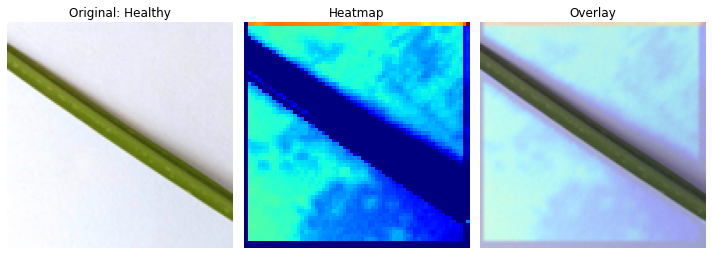

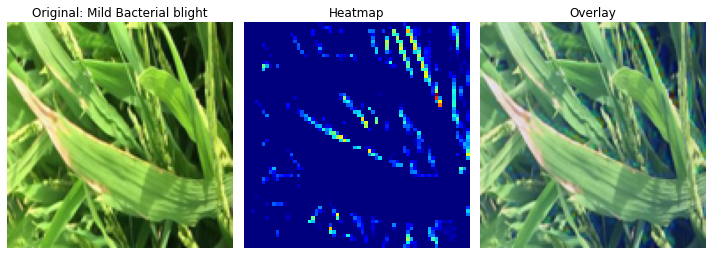

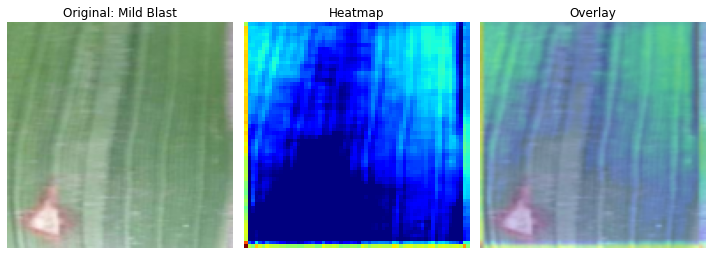

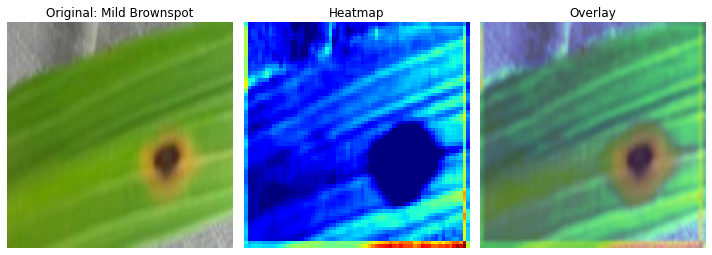

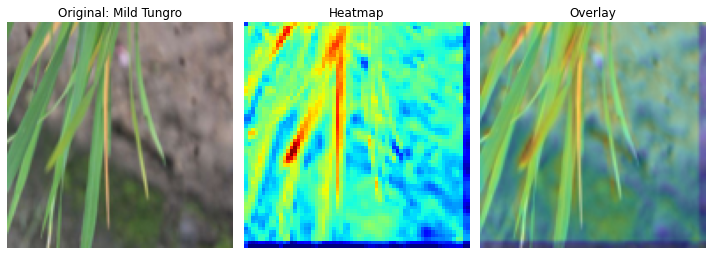

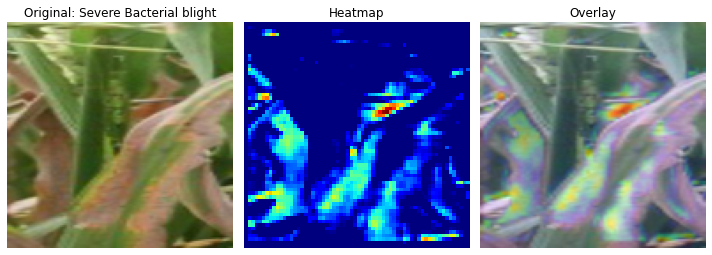

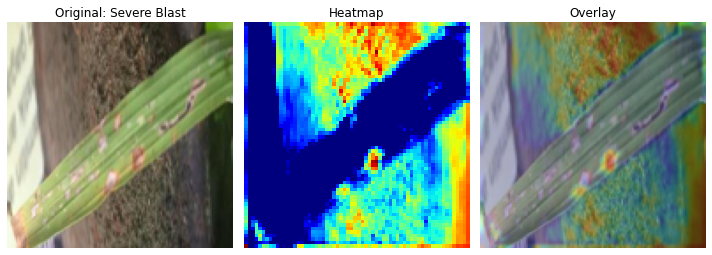

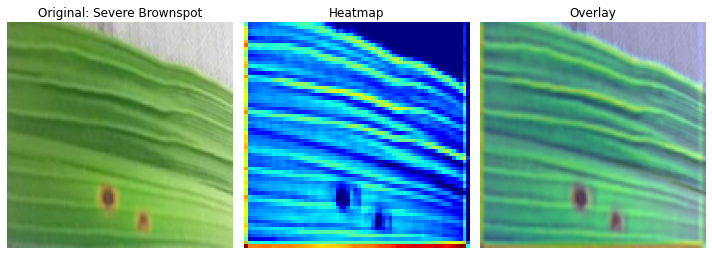

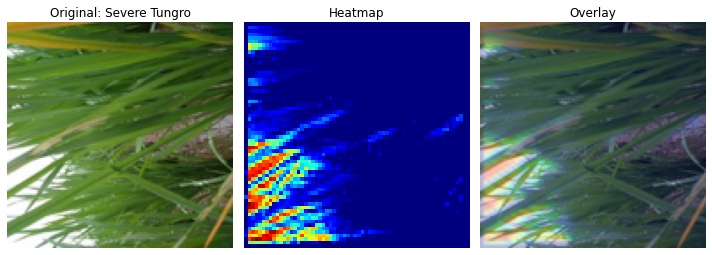

In [17]:
# For each class, pick one example from test set and visualize
for class_idx, class_name in enumerate(class_names):
    # Find an example from that class in x_test
    idx = np.where(y_test == class_idx)[0][0]
    original_img = x_test[idx]
    img_array = get_img_array(original_img)

    # Generate Grad-CAM heatmap for the target class
    heatmap = make_gradcam_heatmap(img_array, ConvNeXt_model, last_conv_layer_name, pred_index=class_idx)

    # Overlay heatmap
    overlay_img = display_gradcam(original_img, heatmap)

    # Plot: original, heatmap, overlay
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))
    ax[0].imshow(original_img)
    ax[0].set_title(f"Original: {class_name}")
    ax[0].axis("off")

    ax[1].imshow(heatmap, cmap="jet")
    ax[1].set_title("Heatmap")
    ax[1].axis("off")

    ax[2].imshow(overlay_img)
    ax[2].set_title("Overlay")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()


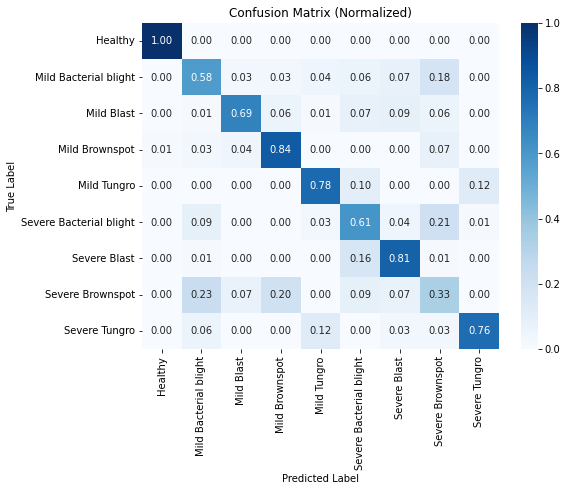

In [18]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get predictions for test set
y_pred_probs = ConvNeXt_model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize for percentages (optional)
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Normalized)")
plt.show()


# References

* https://arxiv.org/abs/2201.03545

* https://github.com/facebookresearch/ConvNeXt

* https://arxiv.org/abs/1512.03385

* https://arxiv.org/abs/2103.14030

* https://arxiv.org/abs/1607.06450

* https://medium.com/@zurister/depth-wise-convolution-and-depth-wise-separable-convolution-37346565d4ec

* https://paperswithcode.com/method/inverted-residual-block

* https://github.com/keras-team/keras/blob/master/keras/applications/convnext.py

* https://paperswithcode.com/method/gelu


# Citation
```bibtex
@Article{liu2022convnet,
  author  = {Zhuang Liu and Hanzi Mao and Chao-Yuan Wu and Christoph Feichtenhofer and Trevor Darrell and Saining Xie},
  title   = {A ConvNet for the 2020s},
  journal = {Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR)},
  year    = {2022},
}
```